In [68]:
import mne
import numpy as np
import os.path as op
from tools import files
from scipy.stats import trim_mean, ttest_1samp, sem
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_topomap
from mne.viz import plot_compare_evokeds
from operator import itemgetter 

%matplotlib qt

In [3]:
# functions
trim = lambda x: trim_mean(x, 0.1, axis=0)

In [4]:
main_path = op.join("/cubric", "scratch", "c1557187", "act_mis")
meg_path = op.join(main_path, "MEG")

In [5]:
participants = files.get_folders_files(meg_path, wp=False)[0]
participants.sort()
participants.remove("0004")
participants.remove("0009")
participants.remove("0042")
print(participants)

['0001', '0003', '0008', '0014', '0015', '0016', '0017', '0019', '0021', '0027', '0030', '0032', '0034', '0035', '0038', '0039', '0040', '0041', '0043']


In [6]:
results_path = op.join(main_path, "RESULTS", "TD_SENSOR_SPACE")
data_analysis_save = op.join(results_path, "data_analysis.npy")
data_viz_save = op.join(results_path, "data_viz.npy")

In [7]:
cond = ["reg", "odd", "diff"]
data = {i: [] for i in cond}

In [8]:
for pp in participants:
    participant_path = op.join(meg_path, pp, "new_v1")
    participant_files = files.get_files(participant_path, "epochs-TD", "-epo.fif")[2]
    print(participant_files)
    for i in participant_files:
        epochs = mne.read_epochs(i, preload=True)
        epochs = epochs.pick_types(selection=[i for i in epochs.info["ch_names"] if "O" in i])
        epochs = epochs.apply_baseline((-0.1, 0.0))
        epochs = epochs.apply_baseline((1.6, 2.6))
        reg = epochs["30"].average(method=trim)
        odd = epochs["40"].average(method=trim)
        diff = mne.combine_evoked([-reg, odd], weights="equal")

        data["reg"].append(reg.data)
        data["odd"].append(odd.data)
        data["diff"].append(diff.data)

['/cubric/scratch/c1557187/act_mis/MEG/0001/new_v1/epochs-TD-000-epo.fif', '/cubric/scratch/c1557187/act_mis/MEG/0001/new_v1/epochs-TD-001-epo.fif']
['/cubric/scratch/c1557187/act_mis/MEG/0003/new_v1/epochs-TD-000-epo.fif', '/cubric/scratch/c1557187/act_mis/MEG/0003/new_v1/epochs-TD-001-epo.fif']
['/cubric/scratch/c1557187/act_mis/MEG/0008/new_v1/epochs-TD-001-epo.fif', '/cubric/scratch/c1557187/act_mis/MEG/0008/new_v1/epochs-TD-000-epo.fif']
['/cubric/scratch/c1557187/act_mis/MEG/0014/new_v1/epochs-TD-001-epo.fif', '/cubric/scratch/c1557187/act_mis/MEG/0014/new_v1/epochs-TD-000-epo.fif']
['/cubric/scratch/c1557187/act_mis/MEG/0015/new_v1/epochs-TD-001-epo.fif', '/cubric/scratch/c1557187/act_mis/MEG/0015/new_v1/epochs-TD-000-epo.fif']
['/cubric/scratch/c1557187/act_mis/MEG/0016/new_v1/epochs-TD-001-epo.fif', '/cubric/scratch/c1557187/act_mis/MEG/0016/new_v1/epochs-TD-000-epo.fif']
['/cubric/scratch/c1557187/act_mis/MEG/0017/new_v1/epochs-TD-000-epo.fif', '/cubric/scratch/c1557187/act_m

In [9]:
analysis_array = {i: np.array([j.transpose() for j in data[i]]) for i in data.keys()}
viz_array = {i: np.array(data[i]) for i in data.keys()}
np.save(data_analysis_save, analysis_array)
np.save(data_viz_save, viz_array)

In [10]:
del analysis_array
del viz_array

### ANALYSIS

In [11]:
viz = np.load(data_viz_save).item()
data = np.load(data_analysis_save).item()

In [25]:
info = mne.io.read_info('/cubric/scratch/c1557187/act_mis/MEG/0043/new_v1/epochs-TD-001-epo.fif')
present_ch_names = info["ch_names"]
present_ch_names = [i[:5] for i in present_ch_names]
present_ch_names = [i for i in present_ch_names if "O" in i]
full_connectivity, full_ch_names = mne.channels.find_ch_connectivity(
    info,
    ch_type="mag"
)

both = set(full_ch_names).intersection(present_ch_names)
indices_full = [full_ch_names.index(x) for x in both]
indices_present = [present_ch_names.index(x) for x in both]
indices_present.sort()

connectivity, ch_names = mne.channels.read_ch_connectivity(
    fname="ctf275",
    picks=indices_full
)

In [27]:
X = [data["reg"], data["odd"]]

In [28]:
threshold = 2.0
p_accept = 0.6
cluster_stats = mne.stats.spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    threshold=threshold,
    tail=0,
    verbose=True,
    n_jobs=-1,
    connectivity=connectivity
)

stat_fun(H1): min=0.000000 max=8.043818
Running initial clustering
Found 81 clusters
Permuting 999 times...
[                                        ]   0.00%  |   
Computing cluster p-values
Done.


In [31]:
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < 1)[0]
print(good_cluster_inds)
print(p_values)

[48]
[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 0.999 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]


In [32]:
p_values

array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 0.999, 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ])

In [79]:
epochs = mne.read_epochs('/cubric/scratch/c1557187/act_mis/MEG/0043/new_v1/epochs-TD-001-epo.fif')
epochs = epochs.pick_types(selection=[i for i in epochs.info["ch_names"] if "O" in i])
info = epochs.info

In [80]:
pos = mne.find_layout(info).pos
indices_full.sort()
pos = pos[indices_full]
pos.shape

(41, 4)

In [81]:
evokeds = {
    "regular": mne.EvokedArray(trim_mean(viz["reg"], 0.1, axis=0), info, tmin=-0.5, comment="regular"),
    "odd": mne.EvokedArray(trim_mean(viz["odd"], 0.1, axis=0), info, tmin=-0.5, comment="odd")
}

In [82]:
colors = {"regular": "crimson", "odd": 'steelblue'}
linestyles = {"regular": '-', "odd": '-'}

In [83]:
for i_clu, clu_idx in enumerate(good_cluster_inds):
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    # get topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)
    sig_times = evokeds["regular"].times[time_inds]
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))
    image, _ = plot_topomap(f_map, pos, mask=mask, axes=ax_topo, cmap='Reds',
                            vmin=np.min, vmax=np.max, show=False)
    divider = make_axes_locatable(ax_topo)
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    plot_compare_evokeds(evokeds, axes=ax_signals, show=False, colors=colors,
                         split_legend=True, truncate_yaxis='max_ticks', picks=ch_inds)
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)

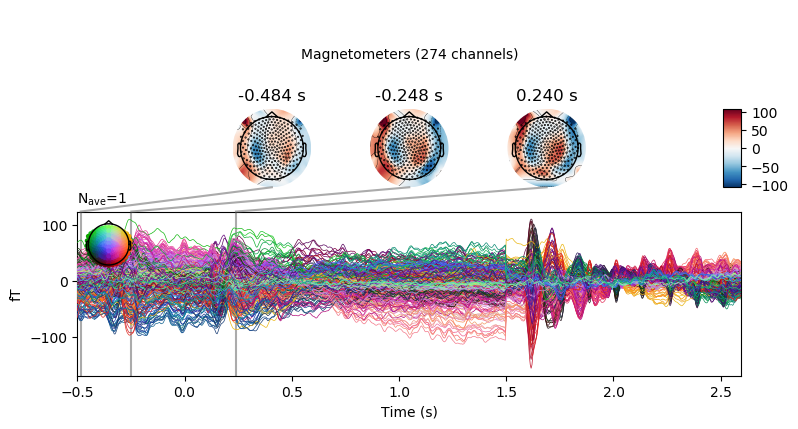